This tutorial was created by Bruno Abreu. It is intellectual property of the University of Illinois. The content is entirely based on Qiskit's documentation and training materials (see references in each section).

The topic of this notebook is **Quantum Machine Learning**. Some of the sections contain exercises.

### Environment setup

`qiskit` is straightforward to install using `pip`. For more information, please visit their documentation: https://qiskit.org/documentation/getting_started.html

For this notebook, we want to include the `visualization` and `machine-learning` modules:

In [1]:
!pip install qiskit[visualization,machine-learning]

In [2]:
import qiskit.tools.jupyter

%qiskit_version_table

### Imports

In [45]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.primitives import Estimator
from qiskit.quantum_info.operators import Operator

import numpy as np
import matplotlib.pyplot as plt

# Quantum machine learning

QML is an emerging research area that brings together Quantum Computing and Machine Learning methods. There are several situations and approaches that can be used by practicioners, depending on the nature of the training dataset, the machine learning method of interest, and the availability of simulators and/or quantum hardware.


A somewhat comprehensive overview of these use cases can be found in Qiskit's ML Intro course: https://learn.qiskit.org/course/machine-learning/introduction

## Parametrized circuits

Many machine learning approaches rely on the ability to use parametrized models. These parameters are then adjusted during the learning (training) process through the interaction with an optimizer that minimizes/maximizes a certain function (objective). A key ingredient for QML is therefore the possibility of including parametrized gates that can composed  *parametrized circuit*. For instance, we can think of an $X$-rotation gate as parametrized gate whose parameter is the angle of qubit rotation around the $X$-axis.


These parametrized circuits can be created with the aid of the `Parameter` and `ParameterVector` classes of the `qiskit.circuit` module.

### Single parameter

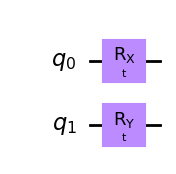

In [7]:
theta = Parameter('t')   # create parameter
qc = QuantumCircuit(2)   # create circuit

qc.rx(theta, 0)          # rotate qubit 0 around x
qc.ry(theta, 1)          # rotate qubit 1 around y

qc.draw('mpl')

### Multiple parameters

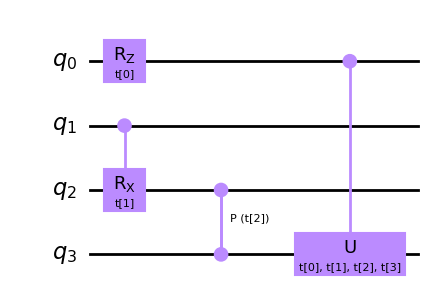

In [10]:
theta_list = ParameterVector('t', length=4)   # create vector of 4 parameters
qc = QuantumCircuit(4)                        # create circuit

qc.rz(theta_list[0], 0)                       # rotate qubit 0 around z with 1st parameter
qc.crx(theta_list[1], 1, 2)                   # controlled x-rotation with 2nd parameter
qc.cp(theta_list[2], 2, 3)                    # controlled-phase gate with 3rd parameter
qc.cu(theta_list[0], theta_list[1],
     theta_list[2], theta_list[3], 0, 3)      # controlled-U gate with all parameters

qc.draw('mpl')

### Binding values to parameters

Having a parametrized circuit can be a flexible solution for certain types of applications but, at some point, these parameters will need to assume a fixed value so that they cn be executed by a simulator or by a real quantum computer.

To *bind* parameters and values, we can use the `QuantumCircuit.bind_parameters()` method: https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html#Binding-parameters-to-values

We can either create many circuits, each with a combination of parameters, or update the circuit's parameters as we simulate them.

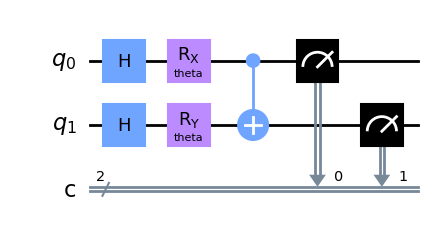

In [39]:
theta = Parameter('theta')   # create parameter
qc = QuantumCircuit(2,2)   # create circuit

qc.h([0,1])              # put each qubit on superposition
qc.rx(theta, 0)          # rotate qubit 0 around x
qc.ry(theta, 1)          # rotate qubit 1 around y
qc.cx(0,1)               # cnot
qc.measure([0,1], [0,1])

qc.draw('mpl')

In [40]:
theta_values = np.linspace(0, 2*np.pi, 32)

qc_bound = qc.bind_parameters({theta: theta_values[5]}) 

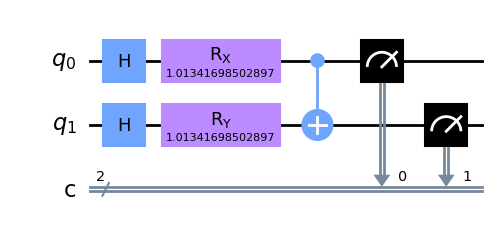

In [41]:
qc_bound.draw('mpl')

We can then simulate several circuits and check on results as a function of these parameters below. In the example below, we are calculating the probability of obtaining the state $\lvert 01 \rangle$ as we sweep $\theta$ in the interval $[0, 2\pi]$:

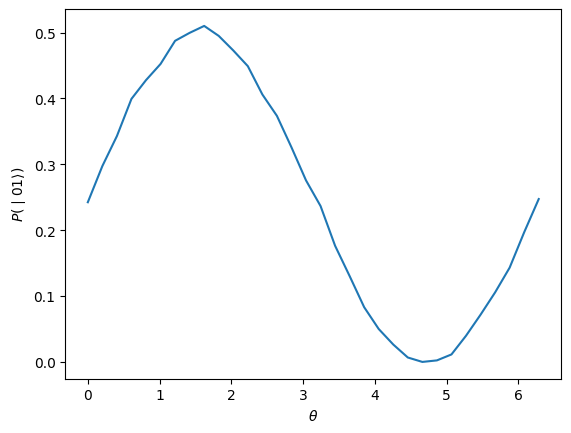

In [54]:
simulator = Aer.get_backend('aer_simulator')
n_shots = 1024*8

probs = []
for t in theta_values:
    qc_bound = qc.bind_parameters({theta: t})
    job = simulator.run(qc_bound, shots=n_shots)
    counts = job.result().get_counts()
    try:
        probs.append(counts['01'])
    except:
        probs.append(0)

plt.figure()
plt.plot(theta_values, np.array(probs)/n_shots)
plt.xlabel(r'$\theta$');
plt.ylabel(r'$P(\vert 01 \rangle)$');

### Exercise

Build a parametrized quantum circuit and study the probability of obtaining a target state as a function of the parameter.

In [201]:
# build the parameter object or parameter vector

In [202]:
# build the parametrized quantum circuit

In [203]:
# simulate several times, binding a different set of parameters each time

In [204]:
# find the probabilities for the target state and plot it as a function of the parameters

## Training circuits

A parametrized circuit can be optimized to find the set of parameters that minimize (or maximize) an objective function $f$. In most quantum mechanics applications, this objective is the *expectation value* of a *Hamiltonian* operator $\hat{H}$.

In a more formal description, the parametrized circuit with characterized by a set of parameters $\vec{\theta}$ prepares a multi-qubit quantum state $\lvert \Psi (\vec{\theta})\rangle$, such that the objective $f(\vec{\theta})$ is explicitly written as

$f(\vec{\theta}) = \langle \Psi (\vec{\theta}) \rvert \hat{H} \lvert \Psi (\vec{\theta}) \rangle$.

The optimization process then follows the standard protocol described in the figure below (from https://learn.qiskit.org/course/machine-learning/training-quantum-circuits)

![opt_protocol](./figs/qiskit_opt_protocol.png)

## Variational quantum eigensolvers

VQEs are a popular quantum algorithm for quantum simulations and optimization problems. Just as described in the last section, it uses a combination of classical and quantum computers to find the quantum state that minimizes a certain function or, in the physics/chemistry context, to find the ground-state of a given system.

Given a parametrized ansatz, the quantum portion of the algorithm calculates the expectation value of the system with respect to an observable $\hat{H}$, and the classical portion uses an optimizer, such as gradient descent, to tune the parameters.

### Physical system example

Suppose we have a three-dimensionl system composed of two lattice sites each one containing a single spin-$1/2$ particle (spin can be up or down). We encode spin-down into the $\lvert 0 \rangle$ computational basis state, and spin-up into $\lvert 1 \rangle$.

Furthermore, supposed that we plug in a magnetic field that has intensity $h_z$ along the $Z$-axis and $h_x$ along the $X$-axis. The Hamiltonian for this system is given by

$\hat{H} = \sum_i h_z \sigma_i^Z + \sum_i h_x \sigma_i^X = h_z \sigma_0^Z + h_z \sigma_1^Z + h_x \sigma_0^X + h_x \sigma_1^X$,

where $\sigma_i$ is the correspoding Pauli matrix for the particle indexed by $i$. 

With the state of each particle encoded by a single qubit, the state of the entire system must be a superposition of the two-qubit computational basis $\mathcal{B} = \{\lvert 00 \rangle, \lvert 01 \rangle, \lvert 10 \rangle, \lvert 11 \rangle\}$. In this basis, $\hat{H}$ has the following representation:

$\begin{bmatrix} -2h_z & h_x  & h_x & 0 \\ h_x & 0 & 0 & h_x \\ h_x & 0 & 0 & h_x \\ 0 & h_x & h_x & 2h_z\end{bmatrix}$

We will use `qiskit.quantum_info`'s `Operator` class to represent this Hamiltonian: https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html

In [193]:
hz = 1.0
hx = 1.0

hamiltonian = [
    [-2.*hz, hx, hx, 0],
    [hx, 0, 0, hx],
    [hx, 0, 0, hx],
    [0, hx, hx, 2.*hz]
]

H = Operator(hamiltonian)

### Circuit ansatz

Knowing that we have two-qubits (four states) and the fact that our system tends to cause rotations around the $Z$- and $X$-axis, our *ansatz* will include four tunable parameters through rotations around the $Y$-axis, and one two-qubit non-parametrized gate to account for possible entanglement:

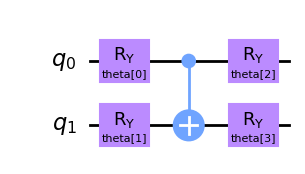

In [194]:
theta_list = ParameterVector('theta', length=4)

ansatz = QuantumCircuit(2)
ansatz.ry(theta_list[0], 0)
ansatz.ry(theta_list[1], 1)
ansatz.cx(0,1)
ansatz.ry(theta_list[2], 0)
ansatz.ry(theta_list[3], 1)

ansatz.draw('mpl')

### Vanilla gradient descent

The parametrized circuit will then prepare the quantum state $\lvert \Psi (\vec{\theta}) \rangle = \lvert \Psi (\theta_0,\theta_1,\theta_2,\theta_3) \rangle$, and we need to calculate the expectation value of $\hat{H}$, *viz.* $f = \langle \Psi (\vec{\theta}) \rvert \hat{H} \lvert \Psi (\vec{\theta}) \rangle$. 

Although it is possible to perform this calculation using the simulation methods we used before, the task is largely facilitated by `qiskit.primitives.Estimator` class: https://qiskit.org/documentation/stubs/qiskit.primitives.Estimator.html

This class allows us to pass the circuit that prepares the quantum state and the operator to be estimated, returning the result we need.

In [195]:
estimator = Estimator()
exp_val = estimator.run([ansatz], [H], [1.,1.,1.,1.])
exp_val.result().values[0]

2.391760343546874

A simple gradient descent implementation is then straightforward. We need to slightly vary each parameter individually to calculate $\frac{\partial f}{\partial \theta_i}$ through

$ \frac{\partial f}{\partial \theta_i} \approx \frac{1}{2\epsilon}\left[f(\theta_0, ..., \theta_i + \epsilon, ..., \theta_N) - f(\theta_0, ..., \theta_i - \epsilon, ..., \theta_N) \right]$,

then update the parameters using

$\theta_i \to \theta_i - \alpha \frac{\partial f}{\partial \theta_i}$

until $f$ converges to the minimum value.

In [196]:
# start random
theta_now = np.random.rand(4)
lr = 0.01
n_iters = 250

energies = []
for _ in range(n_iters):

    #displacement for gradient calculation
    eps = 0.01*theta_now
    theta_new = np.copy(theta_now)

    # loop over each parameter
    for i in range(len(theta_now)):
        # displace up
        theta_up = np.copy(theta_now)
        theta_up[i] = theta_up[i] + eps[i]
        exp_val_up = estimator.run([ansatz], [H], theta_up).result().values[0]

        # displace down
        theta_down = np.copy(theta_now)
        theta_down[i] = theta_down[i] - eps[i]
        exp_val_down = estimator.run([ansatz], [H], theta_down).result().values[0]

        # simple derivative
        df = exp_val_up - exp_val_down
        update = df / (2*eps[i])

        # update
        theta_new[i] = theta_now[i] - lr*update

    theta_now = np.copy(theta_new)
    local_en = estimator.run([ansatz], [H], theta_now).result().values[0]
    energies.append(local_en)

Since we have the Haniltonian in the computational basis, we can also diagonalize it to find the energy of the ground state, and compare with our optimization.

In [197]:
eigs = np.linalg.eig(np.array(hamiltonian))
true_gs = np.min(eigs[0])

target = np.repeat(true_gs, len(energies))

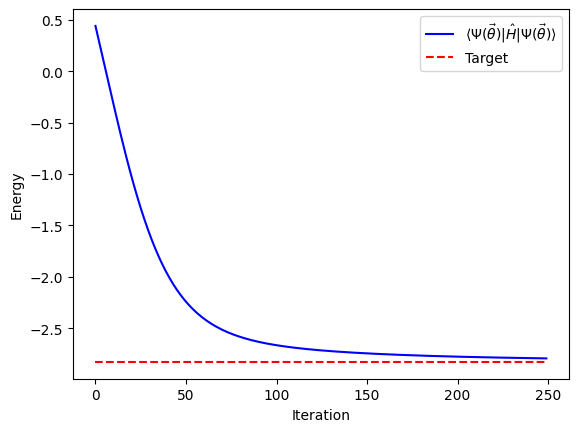

In [198]:
plt.plot(energies, color="blue", label=r'$\langle \Psi(\vec{\theta}) \vert \hat{H} \vert \Psi(\vec{\theta}) \rangle$')
plt.plot(target, color="red", linestyle="dashed", label="Target")
plt.plot()
plt.xlabel('Iteration');
plt.ylabel('Energy');
plt.legend();

### Exercise

Using `Estimator`, the physical system used in this section, and the vanilla gradient descent implementation:

- Change the relative intensity of the $h_x$ and $h_z$ fields. Does the ground state energy change?
- *(Optional)* Try a different ansatz. Can VQE still find the ground state?
- *(Optional)* Bind the parameters to the final optimized value, include a measurement for each qubit, and perform a simulation using the methods we learned in the other notebooks. What states do you get, and with what probabilities?

In [206]:
# re-write the hamiltonian operator with different values of hx and hz

In [207]:
# run the vanilla gradient descent algorithm

In [208]:
# diagonalize the hamiltonian

In [209]:
# verify convergence to the true ground state

## Data encoding

Representing a dataset efficiently is a fundamental step in machine learning approaches, and QML is no exception. Generally, for QML, the central task is to find a way to input the data into a quantum system, which typically translates into finding a quantum state that represents the dataset, or points of the dataset.

There are several ways to perform this *encoding* process:
- Basis encoding
- Angle encoding
- Amplitude encoding
- Arbitraty encoding

Each of these have pros and cons, and they are briefly discussed here: https://learn.qiskit.org/course/machine-learning/data-encoding

### Basis encoding

This is perhaps the most direct way of encoding classical data into a quantum state. In general terms, suppose we have a classical dataset $\mathcal{D}$ with $M$ data samples, each with $N$ features:


$\mathcal{D} = \{x^{(1)}, x^{(2)}, ..., x^{(M)}\}$,


with each $x^{(i)}$ an $N$-dimensional vector. For simplicity, let's consider the case where each entry of these vectors is restricted to a binary representation (the extension to integers is straightforward):

$x = (b_1, b_2, ..., b_N)$

with $b_n \in \{0,1\}$. Then, $x$ can be readily encoded into the computational basis state

$\lvert x \rangle = \lvert b_1, b_2, ..., b_N \rangle$.

For example, if $x = (1, 0, 1, 0)$ (or $x = 10$, since $1 \times 2^3 + 0 \times 2^2 + 1 \times 2^1 + 0 \times 2^ 0 = 10$), then $\lvert x \rangle = \lvert 1010 \rangle$. 

Then, the entire dataset can be represented as the superposition

$\lvert \mathcal{D} \rangle = \frac{1}{\sqrt{M}} \sum_{m=1}^M \lvert x_1^{(m)}, x_2^{(m)}, ..., x_N^{(m)} \rangle$.

As a concrete example, suppose we want to encode the dataset

$\mathcal{D} = \{(0,0,0), (0,1,0), (1,1,1)\} \to \lvert \mathcal{D} \rangle = \frac{1}{\sqrt{3}}\left( \lvert 000 \rangle + \lvert 010 \rangle + \lvert 111 \rangle \right)$.

We can then use the `QuantumCircuit.initialize()` method to prepare the state:

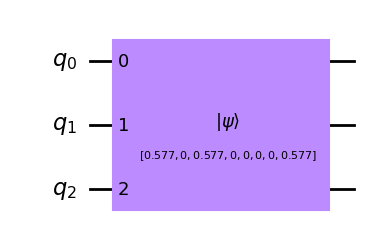

In [199]:
target_state = [
    1. / np.sqrt(3),
    0,
    1. / np.sqrt(3),
    0,
    0,
    0,
    0,
    1. / np.sqrt(3)
]

qc = QuantumCircuit(3)
qc.initialize(target_state, [0,1,2])
qc.draw('mpl')

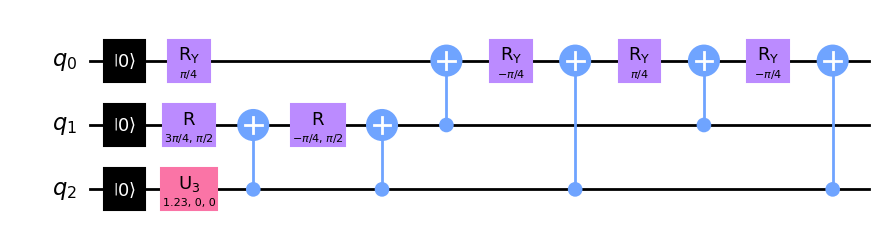

In [200]:
qc.decompose().decompose().decompose().decompose().decompose().decompose().draw('mpl')